In [2]:
from keras.models import Sequential
from keras import layers, metrics
from keras.layers import Dense, Activation, Dropout
import tensorflow as tf
import pickle

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np
import os
import re


os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/NLP_for_onedrive')
from NLP_function import *
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/NLP_for_onedrive/In_Database')

# Import and transform into vector

In [ ]:
X,Y = read_dataset('cli.tokenizing_jy_train.csv', index=102, lan='en')

### Y : One-hot Encoding

In [4]:
Y_onehot, num_classes, lables = onehot(Y) # One-hot Encoding
print(lables)

number of sample  20344
25 levels
Y_onehot shape  (20344, 25)


### Split data

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, Y_train, Y_test = train_test_split(
    X, Y_onehot, test_size=0.4, random_state=10)
#print(x_train, Y_train)
print('x_train shape:', x_train.shape, 'Y_train shape:', Y_train.shape, 'x_test shape:', x_test.shape, 'Y_test shape:', Y_test.shape)

x_train shape: (12206,) Y_train shape: (12206, 25) x_test shape: (8138,) Y_test shape: (8138, 25)


### X : Indexing and Pad Sequence

In [40]:
# creat index of each word
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000) # 1000
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1
print('vocab_size is:', vocab_size)
print('x_train[0] is:', x_train.iloc[0])
print('X_train[0] is:', X_train[0])
print('X_train[2] is:', X_train[2])

vocab_size is: 18879
x_train[0] is: hyperostosis frontalis interna. enlargement inner surface frontal bone overgrowth inner surface frontal bone thick inner surface frontal bone overgrowth inside frontal bone hypertrophy internal surface frontal bone increased ossification internal surface frontal bone excessive growth inner surface frontal bone thick internal surface frontal bone hyperostosis internal surface frontal bone. bony overgrowth internal endosteal surface frontal bone.
X_train[0] is: [2000, 3553, 597, 424, 181, 196, 1, 734, 424, 181, 196, 1, 677, 424, 181, 196, 1, 734, 2156, 196, 1, 333, 485, 181, 196, 1, 8, 143, 485, 181, 196, 1, 403, 96, 424, 181, 196, 1, 677, 485, 181, 196, 1, 2000, 485, 181, 196, 1, 376, 734, 485, 4563, 181, 196, 1]
X_train[2] is: [445, 326, 714]


In [24]:
tokenizer.word_index

for word in ['sperm', 'head', 'abnormal', 'concentration']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

sperm: 1783
head: 71
abnormal: 7
concentration: 31


In [41]:
# pads the sequence of words with zeros （all length 100）
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print('X_train[0] is:', X_train[0])
print('X_train[2] is:', X_train[2])

X_train[0] is: [2000 3553  597  424  181  196    1  734  424  181  196    1  677  424
  181  196    1  734 2156  196    1  333  485  181  196    1    8  143
  485  181  196    1  403   96  424  181  196    1  677  485  181  196
    1 2000  485  181  196    1  376  734  485 4563  181  196    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  

In [15]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#  Load pretrained embeddings

GloVe co-occurrence matrix (faster to compute), Word2Vec neural networks (more accurate)

In [47]:
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/')

embedding_dim =50
embedding_matrix = create_embedding_matrix(
    'NLP_python\Embedding\GloVe\glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [48]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size
# 88.26% model is covered by the pretrained model

0.5964828645585042

#### GlobalMaxPool1D model

In [50]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True)) #  embeddings are additionally trained
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))  # softmax
model.add(layers.Dense(num_classes, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 50)           943950    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 25)                275       
Total params: 944,735
Trainable params: 944,735
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.0129
Testing Accuracy:  0.0112


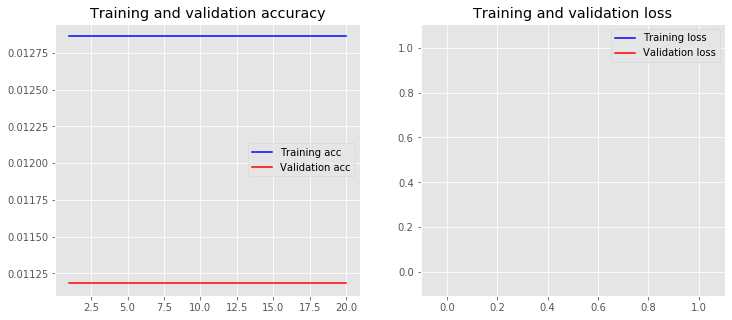

In [52]:
history = model.fit(X_train, Y_train,
                epochs=20,
                verbose=False, 
                validation_data=(X_test, Y_test),
                batch_size=10)
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

##### prediction on individual examples

In [200]:
labels = encoder.categories_
#labels = encoder_lab.classes_

for i in range(1):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = pd.DataFrame(labels)[np.argmax(prediction)]
    print('Actual label   :', Y_test[i])
    print('Predicted label:', Y_test[i])
    print("Predicted label: ", predicted_label,"\n")

Actual label   : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted label:  0    4
Name: 4, dtype: int64 



##### prediction on all and check model metrics

In [205]:
pred_classes = model.predict_classes([X_test], verbose=0)
pred_classes = pred_classes.tolist()
print('for sample [0], predicted classe is :', pred_classes[0])

Y_test_classes = []

for i in range(len(Y_test)):
    tem = pd.DataFrame({'y_id': encoder.categories_[0], 'Y_test': Y_test[i]})
    index = tem[tem['Y_test']==1]['y_id']
    Y_test_classes.append(index.values[0])
print('for sample [0], real classe is :', Y_test_classes[0])

for sample [0], predicted classe is : 4
for sample [0], real classe is : 4


In [221]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test_classes, pred_classes)
print('Accuracy: %f' % accuracy)  # same 
# precision tp / (tp + fp)
precision = precision_score(Y_test_classes, pred_classes, average='weighted') # take into account for label imbalance
print('Precision_macro: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test_classes, pred_classes, average='weighted')
print('Recall_macro: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test_classes, pred_classes, average='weighted')
print('F1 score_macro: %f' % f1)

Accuracy: 0.881041
Precision_macro: 0.842492
Recall_macro: 0.881041
F1 score_macro: 0.852997


##### save model

In [34]:
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/NLP_for_onedrive')

# save model and architecture to single file
model.save("M_GlobalMaxPool1D_HPO_subclass.h5")
print("Saved model to disk")

Saved model to disk


### Convolutional 1D (CNN)

In [114]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size,
                           embedding_dim,
                           input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu')) # 1D Convolutional filter
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(num_classes, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',   # binary_crossentropy
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           10650     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_6 (Dense)              (None, 17)                187       
Total params: 44,255
Trainable params: 44,255
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9972
Testing Accuracy:  0.9950


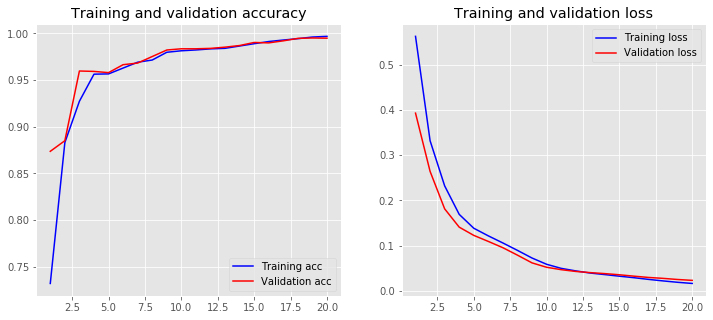

In [115]:
history = model.fit(X_train, Y_train,
                epochs=20,
                verbose=False, 
                validation_data=(X_test, Y_test),
                batch_size=10)
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

##### save model

In [ ]:
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/NLP_for_onedrive')

# save model and architecture to single file
model.save("M_Conv1D_HPO_subclass.h5")
print("Saved model to disk")

### Hyperparameters Optimization

In [13]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=create_model,
                        epochs=20, batch_size=10,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, Y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.9min finished


In [18]:
# Evaluate testing set
test_accuracy = grid.score(X_test, Y_test)
print(test_accuracy)

0.9949704647950524


# Prediction

In [41]:
# load model and tokenizer
loaded_model = tf.keras.models.load_model('M_Conv1D_HPO_subclass.h5') # or Conv1D_model.h5
print('Load model...')
model.summary()

with open('tokenizer_keras_semantic_extension.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

Load model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           10650     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 17)                187       
Total params: 11,347
Trainable params: 11,347
Non-trainable params: 0
_________________________________________________________________


In [ ]:
i = 10
txt = X[i]
txt = loaded_tokenizer.texts_to_sequences([txt])
txt_padded = pad_sequences(txt, padding='post', maxlen=maxlen)

pred = model.predict_classes(txt_padded)
print(X[i], 'Real class is:', Y[i])
print(X[i], 'predicted as class', pred)
print('lables :'.lables.loc[lables['Y_labels']==pred[0]])

###############################################################################

#  Train word embeddings (neural network)

### 1-Dense model

In [ ]:
# load model

from keras.models import Sequential
from keras import layers

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten()) # define 
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# we have 22400 new parameters to train. This number comes from vocab_size times the embedding_dim

### 2-MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D

In the case of max pooling, take the maximum value of all features in the pool for each feature dimension. 
In the case of average pooling, take the average, but max pooling seems to be more commonly used as it highlights large values.
Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size.

In [ ]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_k, Y_labels,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_k, Y_labels),
                    batch_size=10)
loss, accuracy = model.evaluate(X_k, Y_labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_k, Y_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)